# Calculating NDVI from Landsat 8 imagery without a GIS

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) is a simple indicator that can be used to assess whether the target, usually a remotely-sensed raster image, contains live green vegetation.  This calculation uses two bands of a remote dataset, the Red and Near-Infrared (NIR) bands.

\begin{align}
NDVI & = \frac{(NIR - Red)}{(NIR + Red)}
\end{align}

For this tutorial, we'll use the NIR and Red bands from a landsat 8 scene above part of the central valley and the Sierra Nevada in California.  We'll be using [Level 1 datasets](https://landsat.usgs.gov/landsat-processing-details), orthorectified, map-projected images containing radiometrically calibrated data. These images can be individually downloaded from a variety of sources including:

* [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (Account required for download)
* [Amazon AWS](https://aws.amazon.com/public-datasets/landsat/)

The specific scene we'll be using is:

* Collection: `LC08_L1TP_042034_20130605_20170310_01_T1` (Available from USGS Earth Explorer)
* Pre-collection: `LC80420342013156LGN00` ([Available from Amazon AWS](https://landsat-pds.s3.amazonaws.com/L8/042/034/LC80420342013156LGN00/index.html))

More information on Landsat collections here: [https://landsat.usgs.gov/landsat-collections](https://landsat.usgs.gov/landsat-collections)

![Preview of our landsat 8 scene](https://landsat-pds.s3.amazonaws.com/L8/042/034/LC80420342013156LGN00/LC80420342013156LGN00_thumb_small.jpg)

### Bands

* Red: Band 4 (file: ``LC08_L1TP_042034_20130605_20170310_01_T1_B4_120x120.TIF``)
* Near-Infrared: Band 5 (file: ``LC08_L1TP_042034_20130605_20170310_01_T1_B5_120x120.tif``)

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files.  Some other rasters may store multiple bands in the same file.

NB: Landsat scenes are distributed with a 30m pixel resolution.  For the sake of this tutorial and the computational time on our jupyterhub instance, these scenes have been downsampled to 120m.



In [1]:
%matplotlib inline

from osgeo import gdal
import rasterio
from matplotlib import pyplot
import numpy
import pygeoprocessing


L8_RED = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_B4_120x120.TIF'
L8_NIR = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_B5_120x120.TIF'
L8_QA = '../data/landsat/LC08_L1TP_042034_20130605_20170310_01_T1_BQA_120x120.TIF'

def plot(array):
    """Plot a numpy array with an NDVI colormap."""
    pyplot.imshow(array, cmap='RdYlGn')
    pyplot.colorbar()

In [8]:
dataset = gdal.Open(L8_RED)
red = dataset.ReadAsArray()

In [9]:
with rasterio.open(L8_RED) as rio_dataset:
    print rio_dataset.read()

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]


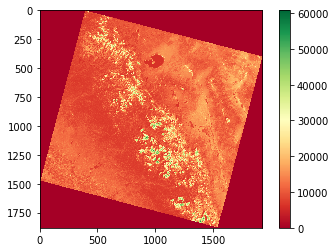

In [10]:
plot(red)

In [12]:
nir = gdal.Open(L8_NIR).ReadAsArray()

/opt/anaconda/envs/rasterenv/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


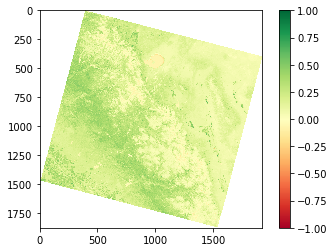

In [18]:
def ndvi(red, nir):
    red = red.astype(numpy.float)
    nir = nir.astype(numpy.float)
    return (nir - red)/(nir + red)

red_2013 = gdal.Open(L8_RED).ReadAsArray()
nir_2013 = gdal.Open(L8_NIR).ReadAsArray()

calculated_ndvi = ndvi(red_2013, nir_2013)
plot(calculated_ndvi)

In [24]:
driver = gdal.GetDriverByName('GTiff')
new_dataset = driver.Create(
    'ndvi.tif',
    dataset.RasterXSize,
    dataset.RasterYSize,
    1,
    gdal.GDT_Float32
)
new_dataset.SetProjection(dataset.GetProjection())
new_dataset.SetGeoTransform(dataset.GetGeoTransform())

band = new_dataset.GetRasterBand(1)
band.WriteArray(calculated_ndvi)
band = None
new_dataset = None

In [25]:
!/opt/anaconda/envs/rasterenv/bin/gdalinfo ndvi.tif

Driver: GTiff/GeoTIFF
Files: ndvi.tif
Size is 1928, 1881
Coordinate System is:
PROJCS["WGS 84 / UTM zone 11N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32611"]]
Origin = (203385.000000000000000,4261815.000000000000000)
Pixel Size = (120.000000000000000,-120.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image S